In [12]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize

import cv2
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib widget
plt.rcParams["figure.figsize"] = (12, 9)

from gecs.io import loader
from gecs.settings import settings
from gecs.experiment import Axes, parse_selector, ExperimentType
from gecs.cvat.nuc_cyto import rle_to_mask
from gecs.segmentation import segment_nuclei_stardist
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
lbl_cmap = random_label_cmap()

from skimage import filters, exposure

In [ ]:
experiment = loader.load_experiment(Path("/nfs/turbo/experiments/ASSDEV006/"), ExperimentType.CQ1).intensity

In [72]:
frame = experiment.sel({Axes.CHANNEL: "DAPI", Axes.REGION:"B06", Axes.FIELD: "6"}).isel({Axes.Z: 0, Axes.TIME: 0}).load()
frame = exposure.rescale_intensity(frame, out_range="float32")

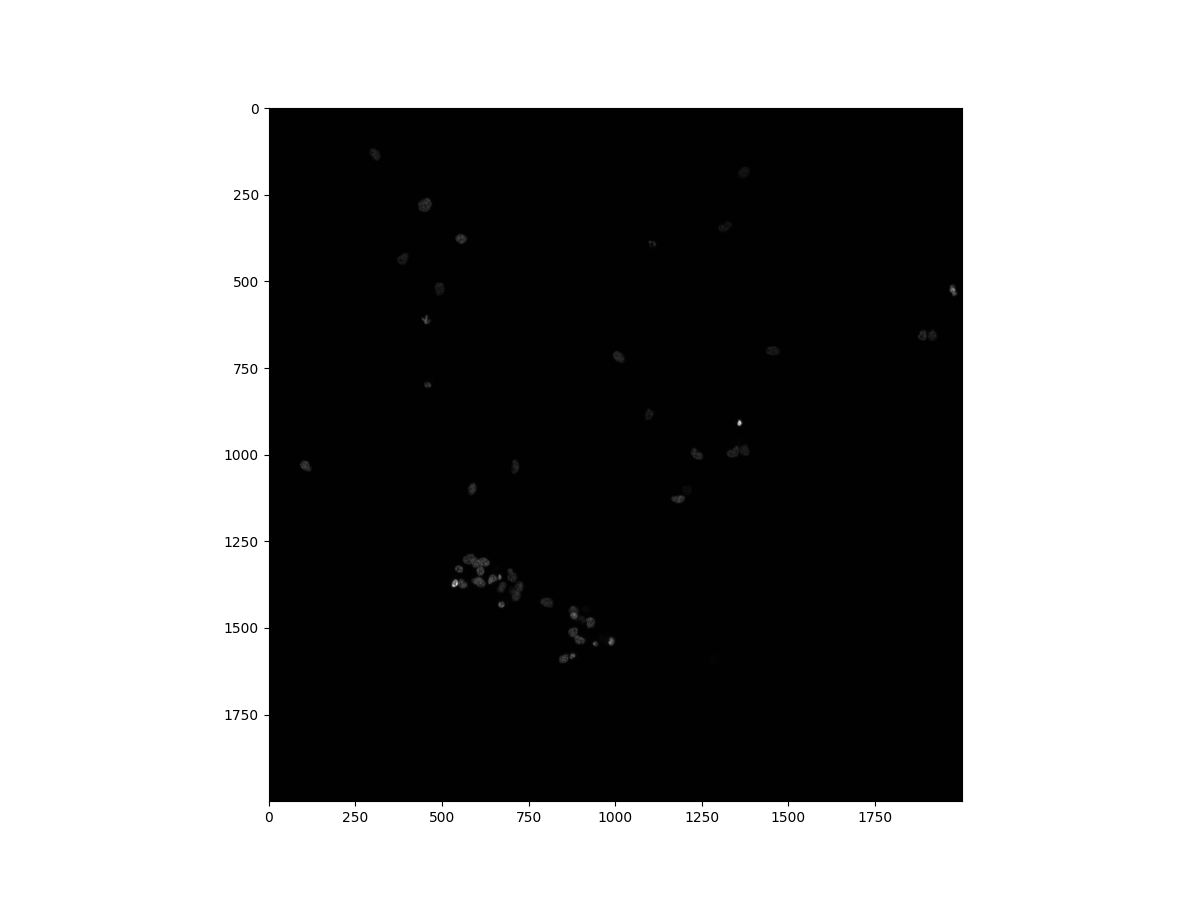

In [73]:
fig, ax = plt.subplots()
ax.imshow(frame, clim=(0,1), cmap="gray")
plt.show()

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
CPU times: user 55.4 ms, sys: 6.2 ms, total: 61.6 ms
Wall time: 26.8 ms


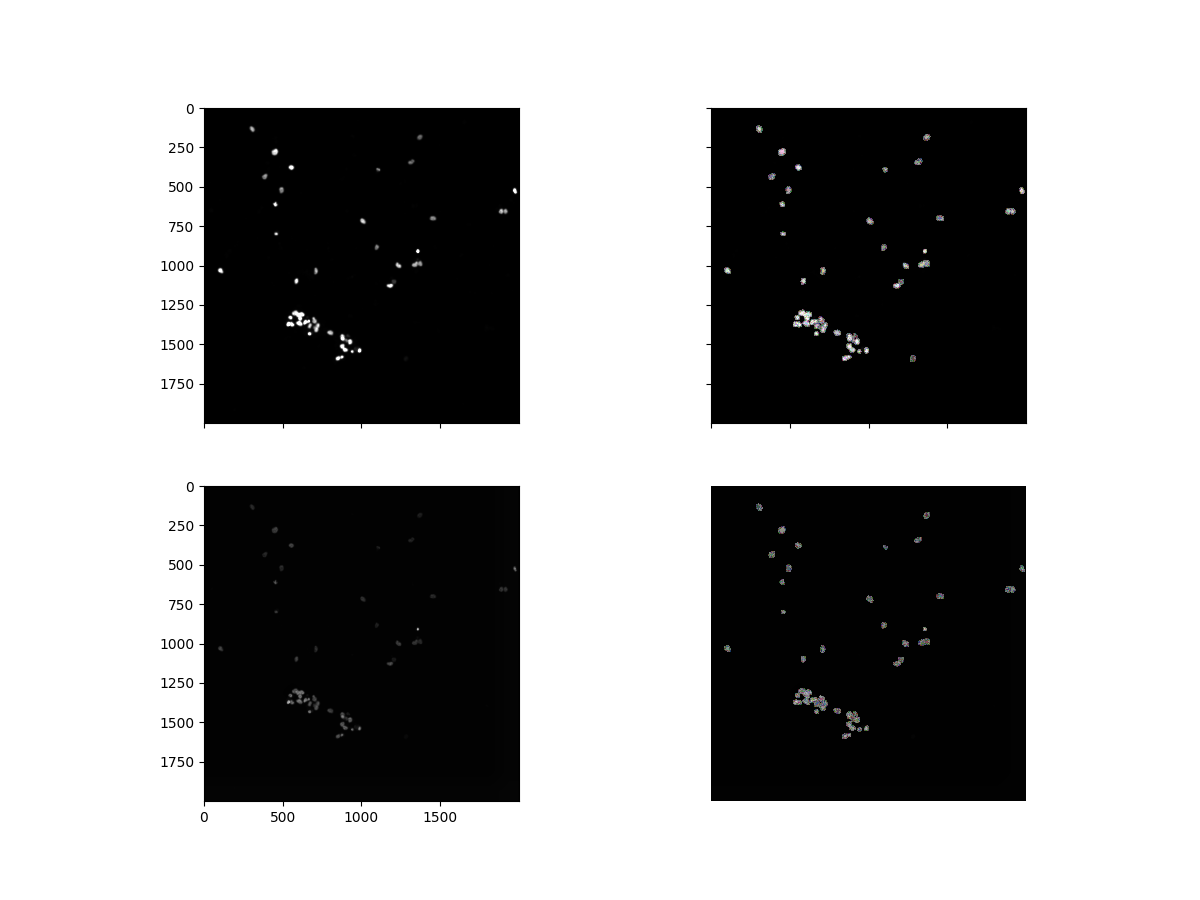

In [89]:
model = StarDist2D.from_pretrained("2D_versatile_fluo")

def bbnorm(img):
    bb_blur = filters.gaussian(img, 3)
    bb_norm = normalize(bb_blur, 1, 99.8)
    return bb_norm

def chadclahe(img):
    rescaled = exposure.rescale_intensity(img, out_range="uint8")
    blurred = cv2.medianBlur(rescaled, 5)
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(16,16))
    return exposure.rescale_intensity(clahe.apply(blurred), out_range="float32")


bbnormd = bbnorm(frame)
bbnormd_pred, _ = model.predict_instances(bbnormd)

%time chadclahed = chadclahe(frame)
chadclahe_pred, _ = model.predict_instances(chadclahed)

fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
ax[0,0].imshow(bbnormd, clim=(0,1), cmap="gray")
ax[0,1].imshow(bbnormd, clim=(0,1), cmap='gray')
ax[0,1].imshow(bbnormd_pred, cmap=lbl_cmap, alpha=0.5)

ax[1,0].imshow(chadclahed, clim=(0,1), cmap="gray")
ax[1,1].imshow(chadclahed, clim=(0,1), cmap="gray")
ax[1,1].imshow(chadclahe_pred, cmap=lbl_cmap, alpha=0.5)
plt.axis("off")
plt.show()